# Multimodal deep learning
This notebook shows an example of training multi-modal, compounding multiple forms for data as input, deep learning with Keras.
Here, I compounded image, natural sound and explanation text, in Japanese.
Each datasets are imported from the following publicly open data.

- image: [Caltech256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/)
- natural sound: [ESC-50](https://github.com/karoldvl/ESC-50)
- text: [Wikipedia](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%82%A4%E3%83%B3%E3%83%9A%E3%83%BC%E3%82%B8)

## Rule

1. Use image, natural sound, and text for input.
2. The model is multiclass classifier.
3. Each row of data is a combination of image, sound, and text in the same category.
    - The combination is generated randomly.
    - The dataset is divided into training and test.
4. One or two columns may be missing in some rows.
    - For instance, missing data may only contain image and sound, with text being None.
    - There may be some data with only one columns: e.g. only text.
    - Both training and test data may have some missing values.
5. The original dataset of images and sounds are downloaded and unzipped.
6. The wikipedia texts are copy-and-pasted manually.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import model_selection
from sklearn import preprocessing
import IPython.display as ipd
from io import BytesIO
from PIL import Image
import cv2
import difflib
import re
import unicodedata
import librosa
import librosa.display
from keras import utils 

# define directories
base_dir = "./"

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---

## Natural sound dataset from [ESC-50](https://github.com/karoldvl/ESC-50)

In [2]:
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

# get data size
data_size = meta_data.shape
print(data_size)

# arrange target label and its name
esc_class_dict = {}
for i in range(data_size[0]):
    if meta_data.loc[i,"target"] not in esc_class_dict.keys():
        esc_class_dict[meta_data.loc[i,"target"]] = meta_data.loc[i,"category"]

(2000, 7)


wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


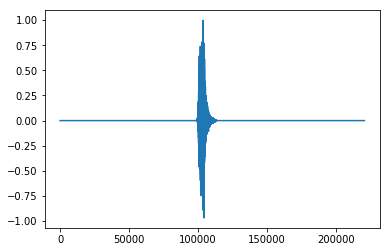

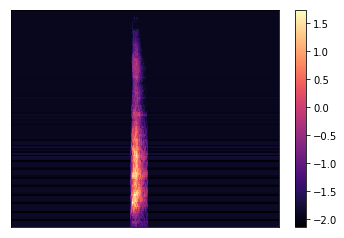

In [3]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

# example data
_x, _fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
_melsp = calculate_melsp(_x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(_x.shape, _melsp.shape, _fs))
show_wave(_x)
show_melsp(_melsp, _fs)

In [4]:
# dict of label to category of the sound dataset
print(esc_class_dict)

{0: 'dog', 14: 'chirping_birds', 36: 'vacuum_cleaner', 19: 'thunderstorm', 30: 'door_wood_knock', 34: 'can_opening', 9: 'crow', 22: 'clapping', 48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water', 45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind', 25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping', 10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby', 49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine', 38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}


---

## Image dataset from [Caltech256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/)

In [5]:
oc256_dir = "./256_ObjectCategories"
oc256_dirs = [os.path.join(oc256_dir, x) for x in os.listdir(oc256_dir)]
oc256_files = [[os.path.join(x,y) for y in os.listdir(x)] for x in oc256_dirs]
oc_class_dict = {int(x.split("/")[-1].split(".")[0]): x.split("/")[-1].split(".")[1] for x in oc256_dirs}

In [6]:
def convert2dgray_to_3dgray(img_array):
    return np.array([[[y,y,y] for y in x] for x in img_array])

def resize_image_array(img_array, image_size=(299, 299)):
    if img_array is None:
        return None
    return cv2.resize(img_array, image_size)

In [7]:
# save image data in npz
def save_np_256_oc_data(x, data_type="train"):
    data_dir = "256_" + data_type
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    for _,c in enumerate(x):
        for _,f in enumerate(c):
            image_name = f.split("/")[3].split(".")[0]
            image_path = os.path.join(data_dir, image_name)
            if not os.path.exists(image_path):
                y = f.split("/")[2].split(".")[0]
                img = Image.open(os.path.join(f))
                img = np.asarray(img)
                if len(img.shape) == 2:
                    img = convert2dgray_to_3dgray(img)
                img = resize_image_array(img, image_size=(299, 299))
                np.savez(image_path, img=img, y=y)

save_np_256_oc_data(oc256_files,  data_type="all")

In [8]:
# dict of label to category of the image dataset
print(oc_class_dict)

{111: 'house-fly', 187: 'skyscraper', 160: 'pez-dispenser', 228: 'triceratops', 42: 'coffin', 103: 'hibiscus', 115: 'ice-cream-cone', 90: 'gorilla', 233: 'tuning-fork', 145: 'motorbikes-101', 38: 'chimp', 236: 'unicorn', 246: 'wine-bottle', 230: 'trilobite-101', 16: 'boom-box', 150: 'octopus', 171: 'refrigerator', 2: 'american-flag', 214: 'teepee', 51: 'cowboy-hat', 159: 'people', 227: 'treadmill', 64: 'elephant-101', 123: 'ketch-101', 119: 'jesus-christ', 3: 'backpack', 180: 'screwdriver', 74: 'flashlight', 157: 'pci-card', 5: 'baseball-glove', 137: 'mars', 139: 'megaphone', 165: 'pram', 121: 'kangaroo-101', 178: 'school-bus', 229: 'tricycle', 58: 'doorknob', 53: 'desk-globe', 212: 'teapot', 158: 'penguin', 176: 'saddle', 213: 'teddy-bear', 177: 'saturn', 114: 'ibis-101', 219: 'theodolite', 107: 'hot-air-balloon', 191: 'sneaker', 102: 'helicopter-101', 4: 'baseball-bat', 144: 'minotaur', 172: 'revolver-101', 239: 'washing-machine', 216: 'tennis-ball', 25: 'cactus', 152: 'owl', 211: 't

## Generate combination of image and sound labels

In [9]:
# look for label that spells similar from the image and sound to make combinations
close_values = []
for ok,ov in oc_class_dict.items():
    for ek,ev in esc_class_dict.items():
        r = difflib.SequenceMatcher(None, ov, ev).ratio()
        if r > 0.6:
            close_values.append([ok,ov,ek,ev,r])
for l in close_values:
    print(l)

[228, 'triceratops', 13, 'crickets', 0.631578947368421]
[58, 'doorknob', 30, 'door_wood_knock', 0.6086956521739131]
[158, 'penguin', 44, 'engine', 0.7692307692307693]
[102, 'helicopter-101', 40, 'helicopter', 0.8333333333333334]
[239, 'washing-machine', 35, 'washing_machine', 0.9333333333333333]
[25, 'cactus', 5, 'cat', 0.6666666666666666]
[152, 'owl', 3, 'cow', 0.6666666666666666]
[245, 'windmill', 16, 'wind', 0.6666666666666666]
[142, 'microwave', 9, 'crow', 0.6153846153846154]
[113, 'hummingbird', 14, 'chirping_birds', 0.64]
[20, 'brain-101', 10, 'rain', 0.6153846153846154]
[7, 'bat', 5, 'cat', 0.6666666666666666]
[210, 'syringe', 28, 'snoring', 0.7142857142857143]
[170, 'rainbow', 45, 'train', 0.6666666666666666]
[170, 'rainbow', 10, 'rain', 0.7272727272727273]
[89, 'goose', 1, 'rooster', 0.6666666666666666]
[73, 'fireworks', 48, 'fireworks', 1.0]
[133, 'lightning', 26, 'laughing', 0.7058823529411765]
[251, 'airplanes-101', 47, 'airplane', 0.7619047619047619]
[56, 'dog', 0, 'dog', 

In [10]:
# These labels seem similar.
# Let's choose these labels as the dataset.
chosen_oc_esc = {
    58:30, #[58, 'doorknob', 30, 'door_wood_knock', 0.6086956521739131]
    102:40, #[102, 'helicopter-101', 40, 'helicopter', 0.8333333333333334]
    239:35, #[239, 'washing-machine', 35, 'washing_machine', 0.9333333333333333] 
    245:16, #[245, 'windmill', 16, 'wind', 0.6666666666666666]
    113:14, #[113, 'hummingbird', 14, 'chirping_birds', 0.64]
    170:10, #[170, 'rainbow', 10, 'rain', 0.7272727272727273]
    89:1, #[89, 'goose', 1, 'rooster', 0.6666666666666666]
    73:48, #[73, 'fireworks', 48, 'fireworks', 1.0]
    251:47, #[251, 'airplanes-101', 47, 'airplane', 0.7619047619047619]
    56:0, #[56, 'dog', 0, 'dog', 1.0]
    80:4 #[80, 'frog', 4, 'frog', 1.0]
}

In [11]:
# dict for Caltech image target label and category name
chosen_kv = {
    58:'door', 
    102:'helicopter',
    239:'washingmachine',
    245:'wind',
    113:'hummingbird',
    170:'rain',
    89:'chicken',
    73:'fireworks',
    251:'airplane',
    56:'dog',
    80:'frog'
}

In [12]:
# texts are downloaded from Wikipedia
textdir = "./wiki"
textfiles = [os.path.join(textdir, x) for x in os.listdir(textdir)]

In [13]:
# make a dict with key as label and value as a list of sentences
oc_txt_dict = {}
for t in textfiles:
    with open(t,'r', encoding='utf-8') as f:
        k = int(t.split("/")[-1].split("_")[0])
        d = f.readlines()
        d = [x.replace("\n","") for x in d]
        oc_txt_dict[k] = d

### Generate a set of training and test dataset

In [14]:
# Generate a compound of image, sound and text for each targets
esc_np_dir = "./ESC-50-master/audio/"
oc_np_dir = "./256_all"

texts_data_train = []
img_data_train = []
snd_data_train = []
target_train = []
category_train = []

texts_data_test = []
img_data_test = []
snd_data_test = []
target_test = []
category_test = []
t = 0

for ok,c in chosen_kv.items():
    oc_list = [os.path.join(oc_np_dir, x) for x in os.listdir(oc_np_dir) if int(x.split("_")[0])==ok]
    esc_list = [os.path.join(esc_np_dir, x) for x in os.listdir(esc_np_dir) if int(x.split("-")[-1].split(".")[0])==chosen_oc_esc[ok]]
    
    # choose test dataset
    test_text = random.sample(range(len(oc_txt_dict[ok])), 8) # list of test text index
    test_img = random.sample(range(len(oc_list)), 8) # list of test image index
    test_snd = random.sample(range(len(esc_list)), 8) # list of test sound index
    # make compound test data
    target_test.extend([t]*8)
    texts_data_test.extend([v for i,v in enumerate(oc_txt_dict[ok]) if i in test_text])
    img_data_test.extend([v for i,v in enumerate(oc_list) if i in test_img])
    snd_data_test.extend([v for i,v in enumerate(esc_list) if i in test_snd])
    category_test.extend([c]*8)
    
    # make test data with one element missing
    missing = random.choices([0,1,2], k=8)
    for _,p in enumerate(missing):
        tt = [0] if p==0 else [oc_txt_dict[ok][random.choice(test_text)]]
        it = [None] if p==1 else [oc_list[random.choice(test_img)]]
        st = [None] if p==2 else [esc_list[random.choice(test_snd)]]
        texts_data_test.extend(tt)
        img_data_test.extend(it)
        snd_data_test.extend(st)
        target_test.extend([t])
        category_test.extend([c])
            
    # make test data with two elements missing
    have = random.choices([0,1,2], k=8)
    for _,p in enumerate(have):
        tt = [oc_txt_dict[ok][random.choice(test_text)]] if p==0 else [0]
        it = [oc_list[random.choice(test_img)]] if p==1 else [None]
        st = [esc_list[random.choice(test_snd)]] if p==2 else [None]
        texts_data_test.extend(tt)
        img_data_test.extend(it)
        snd_data_test.extend(st)
        target_test.extend([t])
        category_test.extend([c])
            
    
    # make compound dataset for training
    train_text = [v for i,v in enumerate(oc_txt_dict[ok]) if i not in test_text] # list of training text
    train_img = [v for i,v in enumerate(oc_list) if i not in test_img] # list of training img
    train_snd = [v for i,v in enumerate(esc_list) if i not in test_snd] # list of training sound
    # allowing some duplicates
    target_train.extend([t]*60)
    texts_data_train.extend(random.choices(train_text, k=60))
    img_data_train.extend(random.choices(train_img, k=60))
    snd_data_train.extend(random.choices(train_snd, k=60))
    category_train.extend([c]*60)
    
    # make train data with one element missing
    missing = random.choices([0,1,2], k=60)
    for _,p in enumerate(missing):
        tt = [0] if p==0 else [random.choice(train_text)]
        it = [None] if p==1 else [random.choice(train_img)]
        st = [None] if p==2 else [random.choice(train_snd)]
        texts_data_train.extend(tt)
        img_data_train.extend(it)
        snd_data_train.extend(st)
        target_train.extend([t])
        category_train.extend([c])
        
    # make train data with two elements missing
    have = random.choices([0,1,2], k=60)
    for _,p in enumerate(have):
        tt = [random.choice(train_text)] if p==0 else [0]
        it = [random.choice(train_img)] if p==1 else [None]
        st = [random.choice(train_snd)] if p==2 else [None]
        texts_data_train.extend(tt)
        img_data_train.extend(it)
        snd_data_train.extend(st)
        target_train.extend([t])
        category_train.extend([c])
        
    t+=1

In [15]:
# make pandas dataframe for better looking
dataset_train = pd.DataFrame({
    "category":category_train,
    "target":target_train,
    "img":img_data_train,
    "snd":snd_data_train,
    "text":texts_data_train
})
dataset_train.to_csv("./dataset_train.csv")
dataset_train

,category,target,img,snd,text
0,door,0,./256_all/058_0051.npz,./ESC-50-master/audio/3-152594-A-30.wav,そのため、開いた状態では基準となる線（扉の閉位置）の両側に扉が張り出す。
1,door,0,./256_all/058_0082.npz,./ESC-50-master/audio/1-103995-A-30.wav,初めて訪れた建物は、非常口の扉の仕組みを確認しておくとよい。
2,door,0,./256_all/058_0055.npz,./ESC-50-master/audio/3-182025-A-30.wav,ドアという言葉も開き戸に対して使われ、通常は引き戸の事はドアとは言わない。
3,door,0,./256_all/058_0063.npz,./ESC-50-master/audio/4-182041-A-30.wav,扉は必要性に応じて、様々な機能性が追加される場合もある。
4,door,0,./256_all/058_0060.npz,./ESC-50-master/audio/4-182041-A-30.wav,そのため、開いた状態では基準となる線（扉の閉位置）の両側に扉が張り出す。
5,door,0,./256_all/058_0087.npz,./ESC-50-master/audio/1-103999-A-30.wav,自動扉（自動ドア）も引き戸である場合が多い。
6,door,0,./256_all/058_0055.npz,./ESC-50-master/audio/4-186518-A-30.wav,バス車両（中扉）や一部の客車においては折戸を2つ組み合わせた「4枚折戸」も存在する。
7,door,0,./256_all/058_0067.npz,./ESC-50-master/audio/3-182023-A-30.wav,引戸の操作性を持つ開戸タイプの扉で、引き代スペースを確保できない場合などに使用される。
8,door,0,./256_all/058_0067.npz,./ESC-50-master/audio/1-81001-B-30.wav,人や物の出入りを主目的しない建物の開口部は窓に分類する。
9,door,0,./256_all/058_0047.npz,./ESC-50-master/audio/3-152594-A-30.wav,一方で、自動車の扉のように交通事故によって変形しても開閉するという機能が妨げられないよう強化...


In [16]:
# make pandas dataframe for better looking
dataset_test = pd.DataFrame({
    "category":category_test,
    "target":target_test,
    "img":img_data_test,
    "snd":snd_data_test,
    "text":texts_data_test
})
dataset_test.to_csv("./dataset_test.csv")
dataset_test

,category,target,img,snd,text
0,door,0,./256_all/058_0043.npz,./ESC-50-master/audio/3-170574-A-30.wav,前述の鍵がその最たる例だが、鍵そのものが強固でも扉が簡単に破壊されては閉鎖の用を成さないため...
1,door,0,./256_all/058_0064.npz,./ESC-50-master/audio/5-235644-A-30.wav,戸袋を持たないものも、機構的にはもちろん引き戸の一つといえる。
2,door,0,./256_all/058_0053.npz,./ESC-50-master/audio/3-154378-A-30.wav,回転扉を導入する利点としては、「建物内の密閉性を維持して冷暖房の空調効果を高めること」と「外...
3,door,0,./256_all/058_0075.npz,./ESC-50-master/audio/2-134915-A-30.wav,主に電気を使い扉を開閉する扉で、ここまでに述べたすべてのタイプの扉には自動扉が存在する。
4,door,0,./256_all/058_0024.npz,./ESC-50-master/audio/1-101336-A-30.wav,自動ドアでないことを強調したいとき、手動ドア、手動扉と言うことがある。
5,door,0,./256_all/058_0032.npz,./ESC-50-master/audio/5-250026-B-30.wav,火災に際して、火災報知機などと連動して、自動的に閉鎖される耐火性のある扉。
6,door,0,./256_all/058_0021.npz,./ESC-50-master/audio/5-251426-A-30.wav,災害などパニックが発生した場合などに、広い開口部に切り替えられる扉。
7,door,0,./256_all/058_0006.npz,./ESC-50-master/audio/4-187284-A-30.wav,なお地震などで建物が歪んでしまった場合、扉の開閉に支障をきたす場合もあるが、パニックオープン...
8,door,0,./256_all/058_0024.npz,None,災害などパニックが発生した場合などに、広い開口部に切り替えられる扉。
9,door,0,None,./ESC-50-master/audio/5-235644-A-30.wav,火災に際して、火災報知機などと連動して、自動的に閉鎖される耐火性のある扉。


### load training and test dataset

In [149]:
x_train_img_path = dataset_train["img"].values
x_test_img_path = dataset_test["img"].values

In [150]:
# load training images
x_train_img = np.zeros((len(x_train_img_path), 299,299,3))
for i,p in enumerate(x_train_img_path):
    if p is not None:
        x_train_img[i] = np.load(p)["img"]
# no normalize for training images, since they will be augmented and normalized during training

# load test images
x_test_img = np.zeros((len(x_test_img_path), 299,299,3))
for i,p in enumerate(x_test_img_path):
    if p is not None:
        x_test_img[i] = np.load(p)["img"]
# normalize
x_test_img = x_test_img.astype('float32')
x_test_img /= 255

print(x_train_img.shape, x_test_img.shape)

(1980, 299, 299, 3) (264, 299, 299, 3)


In [151]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# load a wave data
def load_wave_data(filepath):
    x, _ = librosa.load(filepath, sr=44100)
    return x,_

In [152]:
x_train_snd_path = dataset_train["snd"].values
x_test_snd_path = dataset_test["snd"].values

In [153]:
freq = 128
time = 1723

# load test sounds
x_test_snd = np.zeros((len(x_test_snd_path), freq,time))
for i,p in enumerate(x_test_snd_path):
    if p is not None:
        s,_ = load_wave_data(p)
        x_test_snd[i] = calculate_melsp(s)
    
x_test_snd = x_test_snd.reshape(len(x_test_snd), freq,time, 1)
print(x_test_snd.shape)

(264, 128, 1723, 1)


In [154]:
# convert Japanese characters to unicode
# delete a character randomly with del_rate 
def convert_text_to_unicode(s,del_rate=0.001):
    if s == 0:
        return [0]
    else:
        return [ord(x) for  x in str(s).strip() if random.random() > del_rate]

def reshape_text(s, max_length=200,del_rate=0.001):
    s_ = convert_text_to_unicode(s,del_rate=del_rate)
    s_ = s_[:max_length]
    if len(s_) < max_length:
        s_ += ([0] * (max_length - len(s_)))
    return s_

In [155]:
txt_length = 200

# load texts
x_train_text = dataset_train["text"].values
x_test_text = np.array([reshape_text(t, max_length=txt_length,del_rate=0) for t in dataset_test["text"].values])
print(x_train_text.shape, x_test_text.shape)

(1980,) (264, 200)


In [156]:
y_train = dataset_train["target"].values
y_test = dataset_test["target"].values

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
print(y_train.shape, y_test.shape)

(1980, 11) (264, 11)


## Multi-modal deep learning in convolutional neural network

In [157]:
import keras
from keras import backend as K
from keras import Model, Input
from keras.layers import Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import save_model, load_model
from keras.layers import Activation, Dropout, AlphaDropout, Conv1D, Conv2D, Reshape, Lambda
from keras.layers import GlobalMaxPooling1D, MaxPool2D, MaxPool1D, GlobalMaxPooling2D
from keras.layers import BatchNormalization, Embedding, Concatenate, Maximum,Add

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, recall_score, accuracy_score

In [174]:
# character level cnn for text feature extraction

input_text = Input(shape=(txt_length,), name='input_text')
def clcnn(input_text):
    filter_sizes = (2,3,4,5)

    clx = Embedding(0xffff, 256, name='clx_emb')(input_text)
    convs = []
    for i in range(len(filter_sizes)):
        _clx = Conv1D(filters=256, kernel_size=filter_sizes[i], 
                      strides=(filter_sizes[i]//2), padding="same",
                      name='clx_conv1d_{0}'.format(str(i)))(clx)
        _clx = Activation("tanh",
                      name='clx_act1_{0}'.format(str(i)))(_clx)
        _clx = GlobalMaxPooling1D(name='clx_gmp1d_{0}'.format(str(i)))(_clx)
        convs.append(_clx)
    clx = Concatenate(name='clx_concat')(convs)
    clx = Dense(1024, activation="selu",  kernel_initializer="lecun_normal", name="clx_selu_0")(clx)
    clx = Dropout(0.1, name="clx_dr_0")(clx)
    clx = Dense(256, activation="selu", kernel_initializer="lecun_normal", name="clx_selu_1")(clx)
    return clx

In [175]:
# xception for image feature extraction

input_img = Input(shape=(299, 299, 3), name="input_tensor")
def xception(input_img):
    cnn = keras.applications.Xception(input_tensor=input_img, include_top=False, weights='imagenet')
    xcp = cnn.output
    xcp = GlobalAveragePooling2D(name="xcp_gap2d")(xcp)
    xcp = Dense(256, activation='relu', name="xcp_dense_relu")(xcp)
    return xcp

In [176]:
# cnn for sound feature extraction

input_snd = Input(shape=(freq, time, 1), name="input_snd")
def snd_cnn(input_snd):
    freq = 128
    time = 1723
    def cba(inputs, filters, kernel_size, strides, name):
        x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', name="snd_conv_{0}".format(name))(inputs)
        x = BatchNormalization(name="snd_bn_{0}".format(name))(x)
        x = Activation("relu", name="snd_relu_{0}".format(name))(x)
        return x

    x_1 = cba(input_snd, filters=32, kernel_size=(1,8), strides=(1,2), name="1_0")
    x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1), name="1_1")
    x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2), name="1_2")
    x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1), name="1_3")

    x_2 = cba(input_snd, filters=32, kernel_size=(1,16), strides=(1,2), name="2_0")
    x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1), name="2_1")
    x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2), name="2_2")
    x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1), name="2_3")

    x_3 = cba(input_snd, filters=32, kernel_size=(1,32), strides=(1,2), name="3_0")
    x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1), name="3_1")
    x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2), name="3_2")
    x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1), name="3_3")

    x_4 = cba(input_snd, filters=32, kernel_size=(1,64), strides=(1,2), name="4_0")
    x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1), name="4_1")
    x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2), name="4_2")
    x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1), name="4_3")

    x_snd = Add(name="snd_add")([x_1, x_2, x_3, x_4])

    x_snd = cba(x_snd, filters=128, kernel_size=(1,16), strides=(1,2), name="5_0")
    x_snd = cba(x_snd, filters=128, kernel_size=(16,1), strides=(2,1), name="5_1")

    x_snd = GlobalAveragePooling2D(name="snd_gap")(x_snd)
    snd = Dense(256, activation='relu', name="snd_dense")(x_snd)
    return snd

In [177]:
clx = clcnn(input_text)
xcp = xception(input_img)
snd = snd_cnn(input_snd)

In [178]:
# leave only maximum features to eliminate null inputs
clxcpsnd = Concatenate()([clx, xcp, snd])
clxcpsnd = Dense(256, activation='relu', name="last_dense")(clxcpsnd)

# classification layer
clxcpsnd = Dropout(0.5)(clxcpsnd)
clxcpsnd = Dense(y_train.shape[1], activation='softmax', name="softmax")(clxcpsnd)

model = Model([input_text, input_img, input_snd], clxcpsnd)

In [179]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tensor (InputLayer)       (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_tensor[0][0]               
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [180]:
# optimization
model.compile(optimizer=Adam(lr=1e-4, decay=1e-6, amsgrad=True),
             loss=categorical_crossentropy,
             metrics=['accuracy'])

### input data iterator

In [181]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [182]:
# random erasing for image
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [183]:
# input data generator for training
class MultiModalIterator():
    def __init__(self,
                 x_train_img,
                 x_train_snd_path,
                 x_train_text,
                 y_train,
                 batch_size=8,
                 shuffle=True,
                 datagen=ImageDataGenerator(
                     rotation_range=180,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=10,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     channel_shift_range=5.,
                     brightness_range=[0.3, 1.0],
                     preprocessing_function=get_random_eraser(v_l=0,
                                                              v_h=255))):

        self.x_train_img = x_train_img
        self.x_train_snd_path = x_train_snd_path
        self.x_train_text = x_train_text
        self.y_train = y_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sample_num = len(self.y_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size:(i + 1) * self.batch_size]
                x_text, x_img, x_snd, y = self.__data_generation(batch_ids)

                yield [x_text, x_img, x_snd], y 

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes
    
    def __load_text(self,batch_ids):
        # convert Japanese characters to unicode, with random deletion of del_rate
        x_train_text = np.array([reshape_text(t, max_length=txt_length, del_rate=0.001) for t in self.x_train_text[batch_ids]])
        return x_train_text
    
    def __load_snd(self, batch_ids):
        # load sound data
        x_train_snd = np.zeros((self.batch_size, freq,time))
        for i,p in enumerate(self.x_train_snd_path[batch_ids]):
            if p is not None:
                # load from .wav format
                _x,_ = load_wave_data(p)
                # randomly add augmentation
                if np.random.choice((True,False)):
                    # add white noise
                    _x = add_white_noise(x=_x, rate=np.random.randint(1,50)/1000)
                _t = np.random.choice([0,1,2])
                if _t==1:
                    # shift sound
                    _x = shift_sound(x=_x, rate=np.random.choice(np.arange(2,6)))
                elif _t==2:
                    # stretch sound
                    _x = stretch_sound(x=_x, rate=np.random.choice(np.arange(80,120))/100)
                # convert to melsp numpy array
                x_train_snd[i] = calculate_melsp(_x)
        x_train_snd = x_train_snd.reshape(self.batch_size, freq, time, 1)
        return x_train_snd

    def __data_generation(self, batch_ids):
        x_text = self.__load_text(batch_ids)
        
        x_img = self.x_train_img[batch_ids]
        x_img = x_img.astype('float32')
        for i in range(self.batch_size):
            x_img[i] = self.datagen.random_transform(x_img[i])
            x_img[i] = self.datagen.standardize(x_img[i])
        x_img /= 255
        
        x_snd = self.__load_snd(batch_ids)
        
        y = self.y_train[batch_ids]

        return x_text, x_img, x_snd, y

In [184]:
batch_size = 8
epochs = 40

training_iterator = MultiModalIterator(
    x_train_img,
    x_train_snd_path,
    x_train_text,
    y_train, 
    batch_size=batch_size)()

In [185]:
model_dir = "./model/"
os.makedirs(model_dir, exist_ok=True)
chkpt = os.path.join(model_dir, 'multimodal.{epoch:02d}_{loss:.4f}_{val_loss:.4f}.hdf5')

In [186]:
# train
model.fit_generator(
        training_iterator,
        steps_per_epoch=len(y_train)//batch_size,
        epochs=epochs,
        validation_data=([x_test_text, x_test_img, x_test_snd], y_test),
        workers=6,
        use_multiprocessing=True,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-8),
                    ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')])

Epoch 1/40


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


247/247 [==============================] - 155s 626ms/step - loss: 1.3429 - acc: 0.6032 - val_loss: 1.2012 - val_acc: 0.6477

Epoch 00001: val_loss improved from inf to 1.20124, saving model to ./model/multimodal.01_1.3429_1.2012.hdf5
Epoch 2/40
247/247 [==============================] - 123s 500ms/step - loss: 0.7716 - acc: 0.7758 - val_loss: 1.2334 - val_acc: 0.6553

Epoch 00002: val_loss did not improve from 1.20124
Epoch 3/40
247/247 [==============================] - 114s 460ms/step - loss: 0.6390 - acc: 0.8224 - val_loss: 0.7089 - val_acc: 0.7576

Epoch 00003: val_loss improved from 1.20124 to 0.70891, saving model to ./model/multimodal.03_0.6390_0.7089.hdf5
Epoch 4/40
247/247 [==============================] - 115s 464ms/step - loss: 0.4819 - acc: 0.8725 - val_loss: 0.6353 - val_acc: 0.7576

Epoch 00004: val_loss improved from 0.70891 to 0.63527, saving model to ./model/multimodal.04_0.4819_0.6353.hdf5
Epoch 5/40
247/247 [==============================] - 113s 458ms/step - loss:

Process ForkPoolWorker-49:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-50:
Process ForkPoolWorker-51:
Process ForkPoolWorker-53:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.6/multiprocessing/

  File "/opt/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py", line 878, in power_to_db
    log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))
KeyboardInterrupt


KeyboardInterrupt: 

In [187]:
# accuracy, precision, recall, and f1-score
y_preds = model.predict([x_test_text, x_test_img, x_test_snd])
y_pred_ = np.argmax(y_preds, axis =1)
y_test_ = np.argmax(y_test, axis=1)

print(accuracy_score(y_test_, y_pred_))
print(classification_report(y_test_, y_pred_))
print(confusion_matrix(y_test_, y_pred_))

0.8901515151515151
             precision    recall  f1-score   support

          0       0.85      0.71      0.77        24
          1       0.88      0.92      0.90        24
          2       1.00      0.96      0.98        24
          3       0.95      0.88      0.91        24
          4       1.00      0.92      0.96        24
          5       0.96      0.96      0.96        24
          6       0.79      0.92      0.85        24
          7       0.80      1.00      0.89        24
          8       0.77      0.83      0.80        24
          9       0.95      0.79      0.86        24
         10       0.92      0.92      0.92        24

avg / total       0.90      0.89      0.89       264

[[17  0  0  0  0  0  3  3  1  0  0]
 [ 0 22  0  0  0  1  0  0  1  0  0]
 [ 0  0 23  0  0  0  0  0  1  0  0]
 [ 0  0  0 21  0  0  1  0  2  0  0]
 [ 0  0  0  0 22  0  0  2  0  0  0]
 [ 0  0  0  0  0 23  1  0  0  0  0]
 [ 0  0  0  0  0  0 22  0  1  0  1]
 [ 0  0  0  0  0  0  0 24  0  0  0]
 